In [58]:
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit import transpile
from qiskit.circuit.library import CXGate
from qiskit.dagcircuit import DAGOpNode
from qiskit.converters import circuit_to_dag, dag_to_circuit

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import copy

In [59]:
def grayvalue_to_angle(value):
    return (value/255) * pi/2

def grayscale_to_angles(image_mat):
    for i in range(len(image_mat)):
        for j in range(len(image_mat)):
            image_mat[i][j] = grayvalue_to_angle(image_mat[i][j])
    
    return image_mat

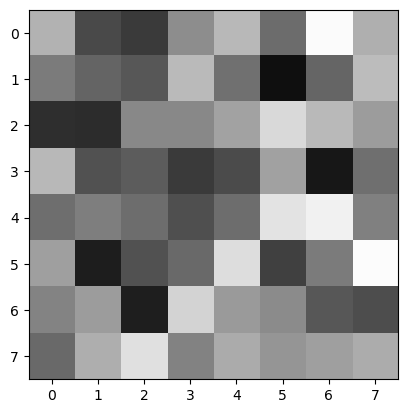

In [60]:
image = np.array([
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0]
]).astype(float)

np.random.seed(123)
rand_image = np.random.rand(8,8)
image = rand_image

image_angles = copy.deepcopy(image)
image_angles = grayscale_to_angles(image_angles)

max_intensity = max([val for row in image for val in row])

_ = plt.imshow(image, cmap='gray', vmin=0, vmax=1)

In [61]:
intensities = [i for image_row in image for i in image_row]
sqrt_intensities = [np.sqrt(i) for i in intensities]
scaled_intensities = [i*(1/np.sqrt(sum(intensities))) for i in sqrt_intensities]
# print(intensities)

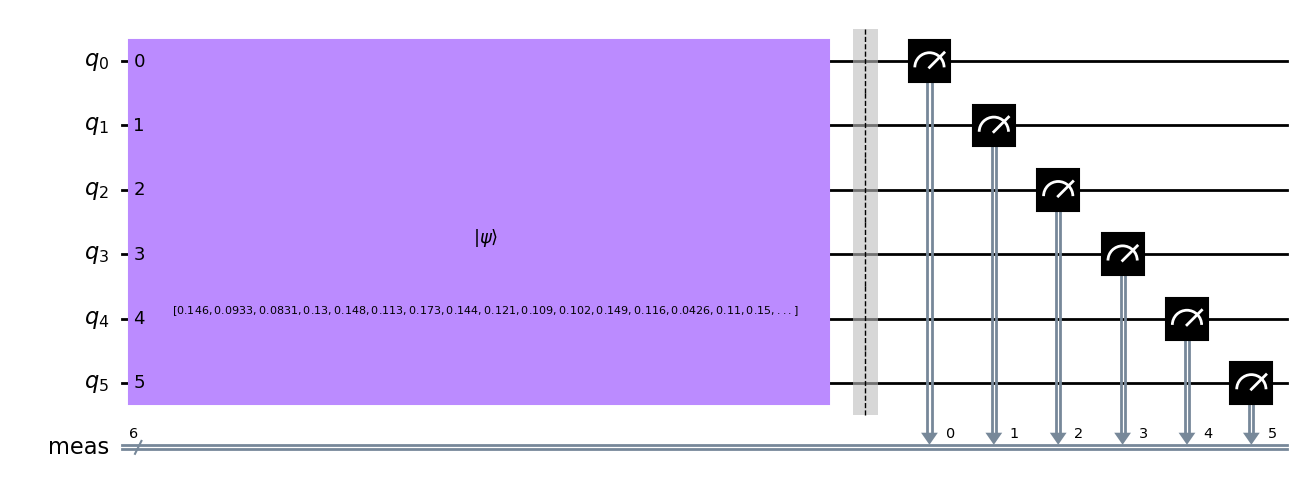

In [65]:
qc = QuantumCircuit(6)

# initialization to match amplitudes
qc.initialize(scaled_intensities)
qc.measure_all()

qc.draw('mpl')

In [66]:
transpiled_circuit = transpile(qc, basis_gates=['cx', 'id', 'rz', 'sx', 'x'], optimization_level=3)
print('Circuit Depth:', transpiled_circuit.depth())
# transpiled_circuit.draw('mpl')

dag = circuit_to_dag(transpiled_circuit)
cxs = dag.op_nodes(CXGate)
for cx in cxs:
    remove = True
    for ancestor in dag.ancestors(cx):
        if isinstance(ancestor, DAGOpNode):
            if ancestor.qargs[0] == cx.qargs[0]:
                remove = False
    if remove:
        dag.remove_op_node(cx)
        
transpiled_circuit = transpile(dag_to_circuit(dag), basis_gates=['rz', 'cx', 'sx'], optimization_level=3)
print('Circuit Depth:', transpiled_circuit.depth())

Circuit Depth: 295
Circuit Depth: 295


{'001101': 63, '001010': 345, '011110': 106, '111101': 525, '010010': 524, '100101': 926, '000001': 287, '001011': 775, '001001': 433, '011011': 240, '010000': 180, '100110': 935, '001100': 419, '101000': 681, '101010': 293, '100100': 412, '111000': 418, '000010': 230, '011101': 600, '110001': 601, '000101': 409, '000000': 714, '011010': 350, '110000': 503, '101111': 996, '011100': 306, '100010': 432, '000011': 572, '100111': 496, '101100': 800, '101001': 98, '010001': 173, '010110': 705, '010111': 595, '010101': 856, '111010': 858, '001000': 437, '111100': 708, '100000': 433, '111110': 658, '000100': 666, '010100': 639, '000111': 636, '110101': 543, '001111': 729, '110110': 331, '111011': 515, '011000': 737, '101101': 259, '110011': 830, '111111': 692, '110100': 603, '101110': 489, '001110': 422, '010011': 532, '011001': 324, '110111': 339, '111001': 664, '100001': 510, '110010': 109, '101011': 441, '011111': 405, '000110': 981, '100011': 280}


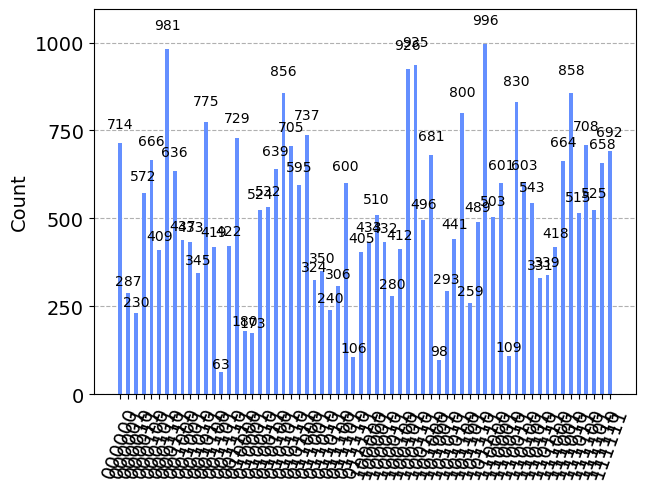

In [68]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
result = aer_sim.run(t_qc, shots=2**15).result()
counts = result.get_counts(qc)

print(counts)
plot_histogram(counts)

In [69]:
# Image reconstruction
highest_count = max(counts.values())
rec_image = [[0 for _ in range(8)] for _ in range(8)]

for k in counts.keys():
    q1 = int(k[:3], 2)
    q2 = int(k[3:], 2)
    
    rec_image[q1][q2] = (counts[k]/highest_count)*max_intensity

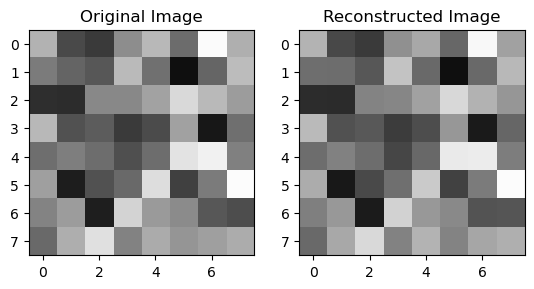

In [70]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

_ = ax1.imshow(image, cmap='gray', vmin=0, vmax=1)
_ = ax1.set_title('Original Image')

_ = ax2.imshow(rec_image, cmap='gray', vmin=0, vmax=1)
_ = ax2.set_title('Reconstructed Image')

In [71]:
image_diff = image - rec_image
squared_diff = 0
for i in range(len(image_diff)):
    for j in range(len(image_diff[i])):
        squared_diff += image_diff[i][j]**2

print('Squared error:', squared_diff)

Squared error: 0.040576991367485
